In [23]:
from clearml import Task

dataset = 'Adult'
task_filter={
    # filter out archived Tasks
    'system_tags': ['-archived'],
    # only completed & published Tasks
    'status': ['completed'],
    # only training type Tasks
    'type': ['training']
}
tags = [dataset]
task_list = Task.get_tasks(
    task_ids=None,  # type Optional[Sequence[str]]
    project_name="AI Fairness",  # Optional[str]
    task_name=None,  # Optional[str]
    task_filter=task_filter,  # Optional[Dict]
    tags=tags
)





In [24]:
%matplotlib widget
sensattr = ['sex']
ages = [(71, 75)]
privacy_in = [['autoencoder'], ['classifier'], ['adversary']]
eps = [1, 3, 10, 30]
arch = ['DP', 'EOD']
len(task_list)

0

In [12]:
import itertools
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
comb = list(itertools.product(sensattr, ages, privacy_in, arch))
comb = [i for i in comb if 'sex' not in i] + [i for i in comb if 'sex' in i and ages[0] in i]
metric_name = ['Accuracy', 'Accuracy Unfair', 'ΔDP', 'ΔDP Unfair', 'ΔEOD', 'ΔEOD Unfair']
print(comb[:2])

[('sex', (71, 75), ['autoencoder'], 'DP'), ('sex', (71, 75), ['autoencoder'], 'EOD')]


In [13]:
def gen_label(l):
    str_ = l[0] if l[0] == 'age' else 'gender'
    if l[0] == 'age':
        str_ += f' {l[1][0]}-{l[1][1]}'
    str_+='|'
    str_ += ' Privacy in'
    for p in l[2]:
        str_ += f' {p}'
    str_+='|'
    str_ += f' {l[3]}'
    return str_

In [14]:
all_metrics = []
for c in tqdm(comb):
    metrics = {n:{k:[] for k in eps} for n in metric_name}
    for task in task_list:
        p = task.get_parameters_as_dict()
        if all([
            p['Args']['sensattr'] == c[0], ast.literal_eval(p['Args']['privacy_in']) == c[2], p['Args']['arch'] == c[3]
        ]):
            if all([c[0] == 'age', int(p['Args']['age_low']) == c[1][0], int(p['Args']['age_high']) == c[1][1]]) or c[0] == 'sex':
                scalars = task.get_reported_scalars()
                arch_ = p['General']['arch']
                e = int(p['Args']['eps'])
                metrics['Accuracy'][e].append(scalars['Accuracy'][f'{arch_} test']['y'][-1])
                metrics['ΔDP'][e].append(scalars['ΔDP'][f'{arch_} test']['y'][-1])
                metrics['ΔEOD'][e].append(scalars['ΔEOD'][f'{arch_} test']['y'][-1])
                metrics['Accuracy Unfair'][e].append(scalars['Accuracy']['Unfair test']['y'][-1])
                metrics['ΔDP Unfair'][e].append(scalars['ΔDP']['Unfair test']['y'][-1])
                metrics['ΔEOD Unfair'][e].append(scalars['ΔEOD']['Unfair test']['y'][-1])
    for m in metrics:
        for i in metrics[m]:
            metrics[m][i] = (np.mean(metrics[m][i]), np.std(metrics[m][i], ddof=1))
    all_metrics.append(metrics)
    
            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:47<00:00,  7.84s/it]


In [16]:
def plot_res(name):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
    for s, m in enumerate(all_metrics):
        mean, std = [], []
        for i in m[name]:
            mean.append(m[name][i][0])
            std.append(m[name][i][1])

        ax.bar(np.arange(len(eps)) + 0.8/len(all_metrics)*s, mean, width=0.8/len(all_metrics), yerr=std, label=gen_label(comb[s]))
    ax.plot(np.arange(0, len(eps)+1), np.repeat(m[f'{name} Unfair'][1][0], len(eps)+1), label='gender Unfair')
    ax.set_title(name)
    ax.set_xticks(np.arange(len(eps)))
    ax.set_xticklabels(eps)
    ax.legend()
    fig.tight_layout()
    plt.show()

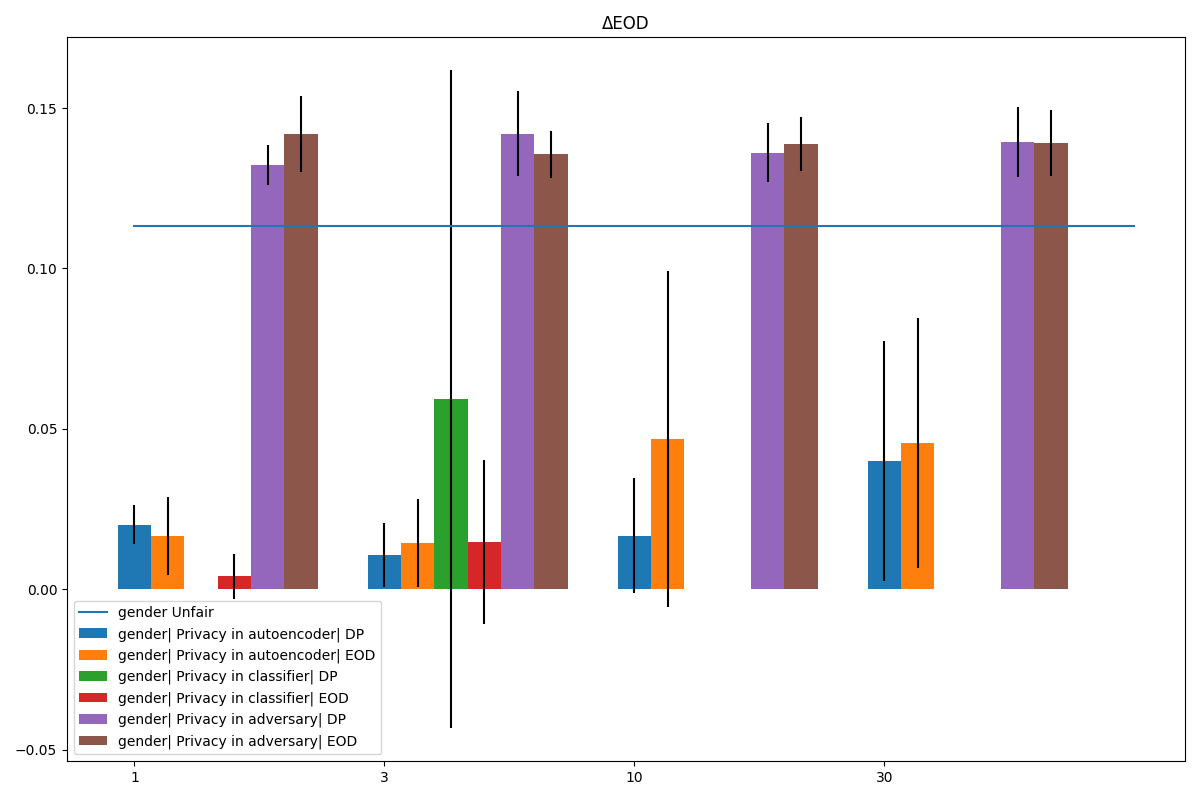

In [19]:
plot_res('ΔEOD')